In [1]:
!pip install pmdarima==1.8.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pmdarima: filename=pmdarima-1.8.1-cp310-cp310-linux_x86_64.whl size=1748920 sha256=c0334208d03a36e61caf023d4a542db29eacaba9b71c37f168a02632af92f602
  Stored in directory: /root/.cache/pip/wheels/92/9c/86/ef0383fb3e8ea43200fc0d2b6eb3b8c419d40c3c534ab3b4aa
Successfully built pmdarima


In [2]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
# from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
#from datetime import datetime

from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/
! mkdir data

/content/drive/MyDrive
mkdir: cannot create directory ‘data’: File exists


In [5]:
!pwd

/content/drive/MyDrive


In [6]:
%cd data/

/content/drive/MyDrive/data


In [7]:
%cp /data.csv /content/drive/MyDrive/data

cp: cannot stat '/data.csv': No such file or directory


In [8]:
! ls

In [9]:
path='/content/drive/MyDrive/Final_nflx_data_2018-2022[1].csv'

In [10]:
#Read the csv file
df = pd.read_csv(path)
df['date'] = pd.to_datetime(df['date']) #convert to datetime
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count
0,2018-01-02,196.100006,201.649994,195.419998,201.070007,201.070007,10966900,0.020833,10,480
1,2018-01-03,202.050003,206.210007,201.500000,205.050003,205.050003,8591400,0.071217,24,337
2,2018-01-04,206.199997,207.050003,204.000000,205.630005,205.630005,6029600,-0.018519,-4,216
3,2018-01-05,207.250000,210.020004,205.589996,209.990005,209.990005,7033200,-0.019737,-6,304
4,2018-01-08,210.020004,212.500000,208.440002,212.050003,212.050003,5580200,-0.007663,-2,261
...,...,...,...,...,...,...,...,...,...,...
1132,2022-07-01,176.490005,180.100006,174.270004,179.949997,179.949997,5194700,-0.062315,-21,337
1133,2022-07-05,176.279999,185.919998,172.679993,185.880005,185.880005,7334300,-0.058824,-25,425
1134,2022-07-06,185.199997,186.220001,180.820007,184.059998,184.059998,5753400,-0.014870,-8,538
1135,2022-07-07,184.270004,190.210007,183.500000,189.270004,189.270004,6334500,-0.055427,-24,433


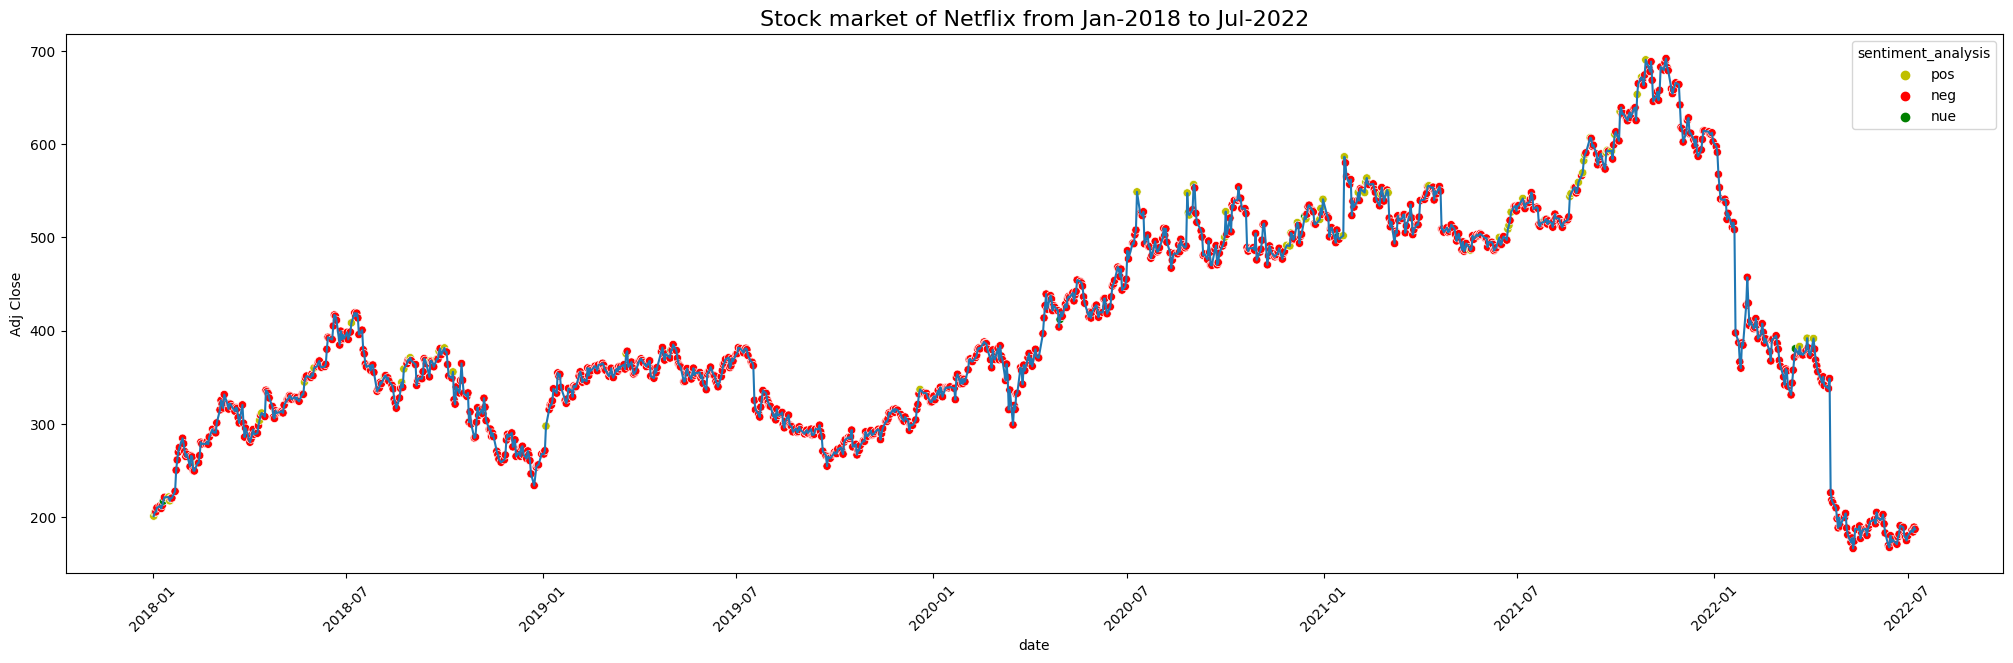

In [11]:
import seaborn as sns #for graphs
plt.figure(figsize=(25,7));
sns.lineplot(x=df["date"],y=df["Adj Close"]) # adjusted close values v/s date
df['sentiment_analysis']=df['P_mean']
df['sentiment_analysis']=df['sentiment_analysis'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg') #segregating on the basis of sentiments
sns.scatterplot(x=df["date"],y=df['Adj Close'],hue=df['sentiment_analysis'],palette=['y','r','g'])
plt.xticks(rotation=45);
plt.title("Stock market of Netflix from Jan-2018 to Jul-2022",fontsize=16);

In [12]:
df=df.replace({'pos': 1, 'nue': 0, 'neg': -1})

In [13]:
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count,sentiment_analysis
0,2018-01-02,196.100006,201.649994,195.419998,201.070007,201.070007,10966900,0.020833,10,480,1
1,2018-01-03,202.050003,206.210007,201.500000,205.050003,205.050003,8591400,0.071217,24,337,1
2,2018-01-04,206.199997,207.050003,204.000000,205.630005,205.630005,6029600,-0.018519,-4,216,-1
3,2018-01-05,207.250000,210.020004,205.589996,209.990005,209.990005,7033200,-0.019737,-6,304,-1
4,2018-01-08,210.020004,212.500000,208.440002,212.050003,212.050003,5580200,-0.007663,-2,261,-1
...,...,...,...,...,...,...,...,...,...,...,...
1132,2022-07-01,176.490005,180.100006,174.270004,179.949997,179.949997,5194700,-0.062315,-21,337,-1
1133,2022-07-05,176.279999,185.919998,172.679993,185.880005,185.880005,7334300,-0.058824,-25,425,-1
1134,2022-07-06,185.199997,186.220001,180.820007,184.059998,184.059998,5753400,-0.014870,-8,538,-1
1135,2022-07-07,184.270004,190.210007,183.500000,189.270004,189.270004,6334500,-0.055427,-24,433,-1


In [14]:
train_dates = pd.to_datetime(df['date'])
# print(train_dates.tail(15)) #Check last few dates.

#Variables for training
cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'P_mean'
        ]
#Date and volume columns are not used in training.
print(cols)

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
df_for_training.index=df['date']
df_for_training

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean']


,Open,High,Low,Close,Volume,Adj Close,P_mean
date,,,,,,,
2018-01-02,196.100006,201.649994,195.419998,201.070007,10966900.0,201.070007,0.020833
2018-01-03,202.050003,206.210007,201.500000,205.050003,8591400.0,205.050003,0.071217
2018-01-04,206.199997,207.050003,204.000000,205.630005,6029600.0,205.630005,-0.018519
2018-01-05,207.250000,210.020004,205.589996,209.990005,7033200.0,209.990005,-0.019737
2018-01-08,210.020004,212.500000,208.440002,212.050003,5580200.0,212.050003,-0.007663
...,...,...,...,...,...,...,...
2022-07-01,176.490005,180.100006,174.270004,179.949997,5194700.0,179.949997,-0.062315
2022-07-05,176.279999,185.919998,172.679993,185.880005,7334300.0,185.880005,-0.058824
2022-07-06,185.199997,186.220001,180.820007,184.059998,5753400.0,184.059998,-0.014870


In [15]:
scaler = MinMaxScaler() # scaling values between 0 and 1
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled
# df_for_training_scaled=df_for_training.copy()
# df_for_training_scaled=df_for_training_scaled.to_numpy()

array([[0.06082629, 0.05594312, 0.06249759, ..., 0.07427889, 0.066055  ,
        0.8357873 ],
       [0.0720869 , 0.06456433, 0.07411439, ..., 0.05631581, 0.07363132,
        0.98677344],
       [0.07994094, 0.06615243, 0.07889104, ..., 0.03694397, 0.07473542,
        0.71785961],
       ...,
       [0.04019756, 0.02677103, 0.03460201, ..., 0.0348554 , 0.03367472,
        0.72879365],
       [0.03843751, 0.03431458, 0.03972256, ..., 0.03924957, 0.04359249,
        0.60725335],
       [0.04174946, 0.03374739, 0.03828956, ..., 0.03544446, 0.03923323,
        0.6444625 ]])

In [16]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0,-2]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (1132, 5, 7).
TrainY shape = (1132, 1, 2).


In [18]:
from sklearn.model_selection import train_test_split

In [19]:
df_arima=df_for_training.copy()
# df_arima['Volume']=df['Volume']
n_past_for_arima=1
adj_close_feature=df_arima['Adj Close']
open_feature=df_arima['Open']
df_arima['Adj Close']=df_arima['Adj Close'].shift(-n_past_for_arima)
df_arima['Open']=df_arima['Open'].shift(-n_past_for_arima)
df_arima.dropna(inplace=True)
df_arima['Adj Close_feature']=adj_close_feature.iloc[:-1]
df_arima['open_feature_feature']=open_feature.iloc[:-1]
# df_arima=df_arima.reindex(columns=['open_lag','High', 'Low', 'Close', 'adj_close_lag','P_mean','Adj Close','Open',])
X_arima=df_arima.drop(['Adj Close','Open'],axis=1)
y_arima=df_arima[['Open','Adj Close']]
X_train_arima_twitter, X_test_arima_twitter, y_train_arima, y_test_arima=train_test_split(X_arima, y_arima, test_size=0.2, shuffle=False)

X_train_arima_without_twitter, X_test_arima_without_twitter= X_train_arima_twitter.drop('P_mean', axis=1), X_test_arima_twitter.drop('P_mean', axis=1)
X_train_arima_without_twitter

,High,Low,Close,Volume,Adj Close_feature,open_feature_feature
date,,,,,,
2018-01-02,201.649994,195.419998,201.070007,10966900.0,201.070007,196.100006
2018-01-03,206.210007,201.500000,205.050003,8591400.0,205.050003,202.050003
2018-01-04,207.050003,204.000000,205.630005,6029600.0,205.630005,206.199997
2018-01-05,210.020004,205.589996,209.990005,7033200.0,209.990005,207.250000
2018-01-08,212.500000,208.440002,212.050003,5580200.0,212.050003,210.020004
...,...,...,...,...,...,...
2021-08-04,517.979980,510.369995,517.349976,2039400.0,517.349976,513.000000
2021-08-05,525.409973,514.020020,524.890015,2556700.0,524.890015,517.130005
2021-08-06,526.840027,519.390015,520.549988,1919800.0,520.549988,524.000000


In [20]:
X_train_arima_twitter

,High,Low,Close,Volume,P_mean,Adj Close_feature,open_feature_feature
date,,,,,,,
2018-01-02,201.649994,195.419998,201.070007,10966900.0,0.020833,201.070007,196.100006
2018-01-03,206.210007,201.500000,205.050003,8591400.0,0.071217,205.050003,202.050003
2018-01-04,207.050003,204.000000,205.630005,6029600.0,-0.018519,205.630005,206.199997
2018-01-05,210.020004,205.589996,209.990005,7033200.0,-0.019737,209.990005,207.250000
2018-01-08,212.500000,208.440002,212.050003,5580200.0,-0.007663,212.050003,210.020004
...,...,...,...,...,...,...,...
2021-08-04,517.979980,510.369995,517.349976,2039400.0,-0.050980,517.349976,513.000000
2021-08-05,525.409973,514.020020,524.890015,2556700.0,-0.036424,524.890015,517.130005
2021-08-06,526.840027,519.390015,520.549988,1919800.0,-0.066351,520.549988,524.000000


In [21]:
from pmdarima import auto_arima
arima_model_for_open_without_twitter = auto_arima(y_train_arima['Open'], exogenous=X_train_arima_without_twitter,
                                                  start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                                  seasonal=True,
                                                  error_action='ignore',
                                                  suppress_warnings=True,
                                                  stepwise=True
                                                  )

arima_model_for_open_twitter = auto_arima(y_train_arima['Open'], exogenous=X_train_arima_twitter,
                                          start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                          seasonal=True,
                                          error_action='ignore',
                                          suppress_warnings=True,
                                          stepwise=True
                                          )
arima_model_for_open_without_twitter.summary()
arima_model_for_open_twitter.summary()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  908
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -2879.379
Date:                Thu, 22 Jun 2023   AIC                           5776.757
Time:                        13:47:18   BIC                           5820.059
Sample:                             0   HQIC                          5793.292
                                - 908                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
High                     0.2290      0.047      4.922      0.000       0.138       0.320
Low                      0.2729      0.040      6.904      0.000       0.195       0.350
Close                    0.3592      0.020     17.608      0.000       0.319       0.399
Volume                8.685e-08   2.72e-08      3.189      0.001    3.35e-08     1.4e-07
P_mean                  18.3556      0.039    473.084      0.000      18.280      18.432
Adj Close_feature        0.3592      0.020     17.608      0.000       0.319       0.399
open_feature_feature    -0.2176      0.043     -5.105      0.000      -0.301      -0.134
ar.L1                   -0.0497      0.035     -1.422      0.155      -0.118       0.019
sigma2                  33.2966      0.407     81.731      0.000      32.498      34.095
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             32395.33
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                            -0.33
Prob(H) (two-sided):                  0.01   Kurtosis:                        32.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.44e+20. Standard errors may be unstable.
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


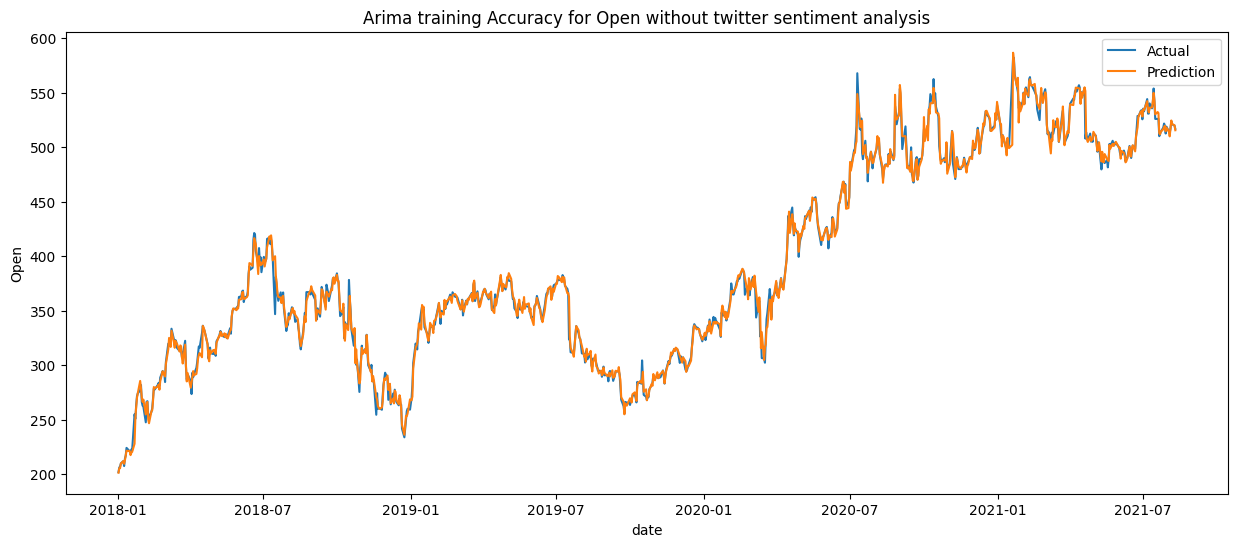

Training mean square error for open feature without twitter 34.05106320502237


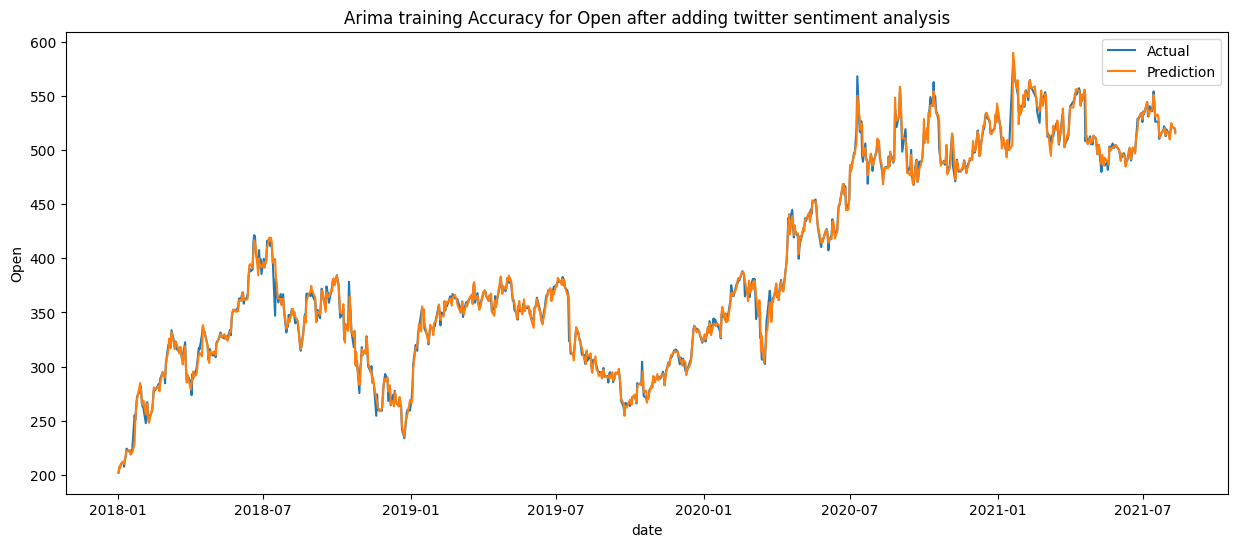

Training mean square error for open feature with twitter 33.34257716566714


In [22]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
train_prediction_without_twitter= arima_model_for_open_without_twitter.predict(n_periods=len(X_train_arima_without_twitter), exogenous=X_train_arima_without_twitter)
train_prediction_twitter= arima_model_for_open_twitter.predict(n_periods=len(X_train_arima_twitter), exogenous=X_train_arima_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arima['Open'].index, y=y_train_arima['Open'], label='Actual')
sns.lineplot(x=y_train_arima['Open'].index, y=train_prediction_without_twitter, label='Prediction')
plt.title('Arima training Accuracy for Open without twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_without_twitter, y_train_arima['Open'])
print(f'Training mean square error for open feature without twitter {e}')

plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arima['Open'].index, y=y_train_arima['Open'], label='Actual')
sns.lineplot(x=y_train_arima['Open'].index, y=train_prediction_twitter, label='Prediction')
plt.title('Arima training Accuracy for Open after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_twitter, y_train_arima['Open'])
print(f'Training mean square error for open feature with twitter {e}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


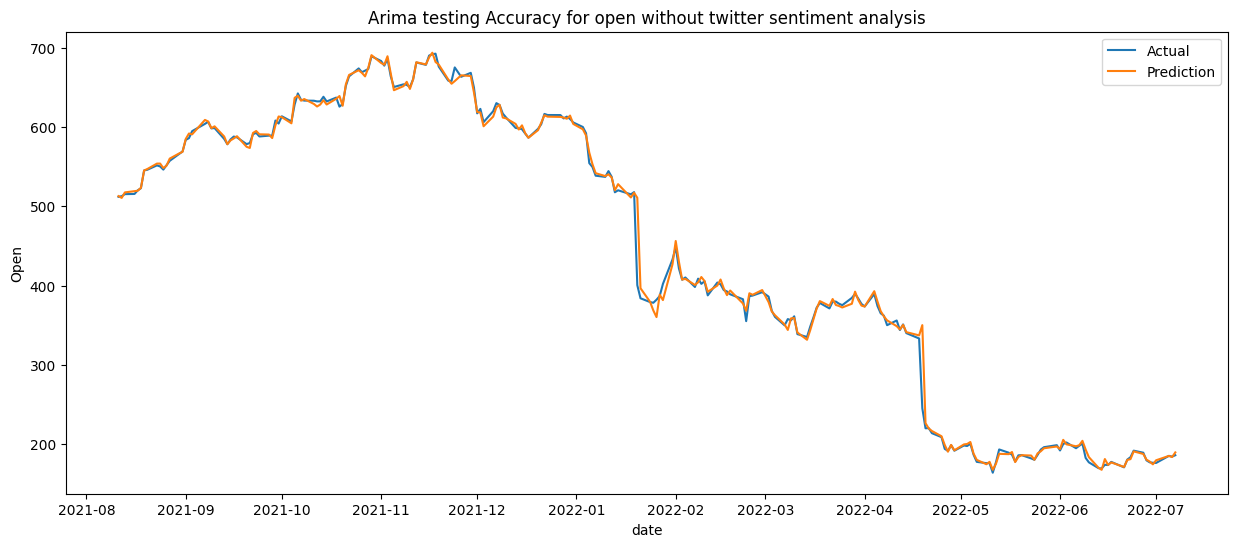

Testing mean square error for open feature without twitter sentiment analysis 122.54653310445053


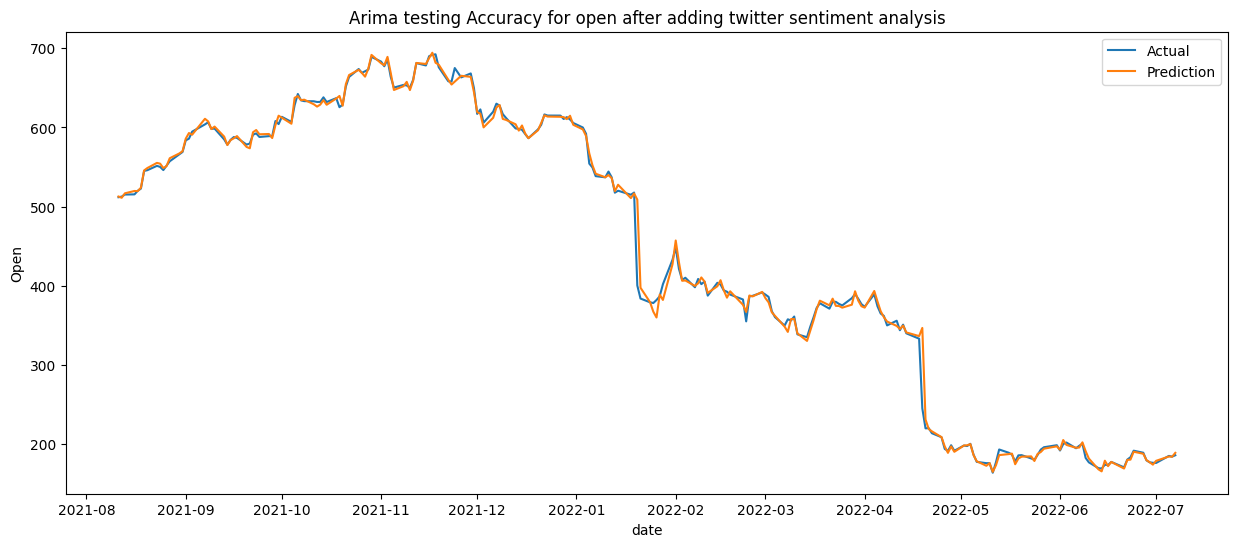

Testing mean square error for open feature with twitter sentiment analysis 119.53329134000347


In [23]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
test_prediction_without_twitter= arima_model_for_open_without_twitter.predict(n_periods=len(X_test_arima_without_twitter), exogenous=X_test_arima_without_twitter)
test_prediction_twitter= arima_model_for_open_twitter.predict(n_periods=len(X_test_arima_twitter), exogenous=X_test_arima_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arima['Open'].index, y=y_test_arima['Open'], label='Actual')
sns.lineplot(x=y_test_arima['Open'].index, y=test_prediction_without_twitter, label='Prediction')
plt.title('Arima testing Accuracy for open without twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_without_twitter, y_test_arima['Open'])
print(f'Testing mean square error for open feature without twitter sentiment analysis {e}')

plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arima['Open'].index, y=y_test_arima['Open'], label='Actual')
sns.lineplot(x=y_test_arima['Open'].index, y=test_prediction_twitter, label='Prediction')
plt.title('Arima testing Accuracy for open after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_twitter, y_test_arima['Open'])
print(f'Testing mean square error for open feature with twitter sentiment analysis {e}')

In [24]:
from pmdarima import auto_arima
arima_model_for_Adj_Close_without_twitter = auto_arima(y_train_arima['Adj Close'], exogenous=X_train_arima_without_twitter,
                                                  start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                                  seasonal=True,
                                                  error_action='ignore',
                                                  suppress_warnings=True,
                                                  stepwise=True
                                                  )

arima_model_for_Adj_Close_twitter = auto_arima(y_train_arima['Adj Close'], exogenous=X_train_arima_twitter,
                                          start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                          seasonal=True,
                                          error_action='ignore',
                                          suppress_warnings=True,
                                          stepwise=True
                                          )
arima_model_for_Adj_Close_without_twitter.summary()
arima_model_for_Adj_Close_twitter.summary()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  908
Model:                        SARIMAX   Log Likelihood               -3382.123
Date:                Thu, 22 Jun 2023   AIC                           6782.247
Time:                        13:47:45   BIC                           6825.548
Sample:                             0   HQIC                          6798.781
                                - 908                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept                0.2325      0.000   1172.461      0.000       0.232       0.233
High                     0.2231      0.084      2.644      0.008       0.058       0.389
Low                      0.3699      0.084      4.389      0.000       0.205       0.535
Close                    0.2834      0.037      7.626      0.000       0.211       0.356
Volume                 6.18e-08   5.88e-08      1.052      0.293   -5.34e-08    1.77e-07
P_mean                  18.4026      0.000   7.28e+04      0.000      18.402      18.403
Adj Close_feature        0.2834      0.037      7.626      0.000       0.211       0.356
open_feature_feature    -0.1557      0.075     -2.063      0.039      -0.304      -0.008
sigma2                 100.6933      0.000   2.18e+05      0.000     100.692     100.694
===================================================================================
Ljung-Box (L1) (Q):                   1.49   Jarque-Bera (JB):              2096.84
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.46e+21. Standard errors may be unstable.
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


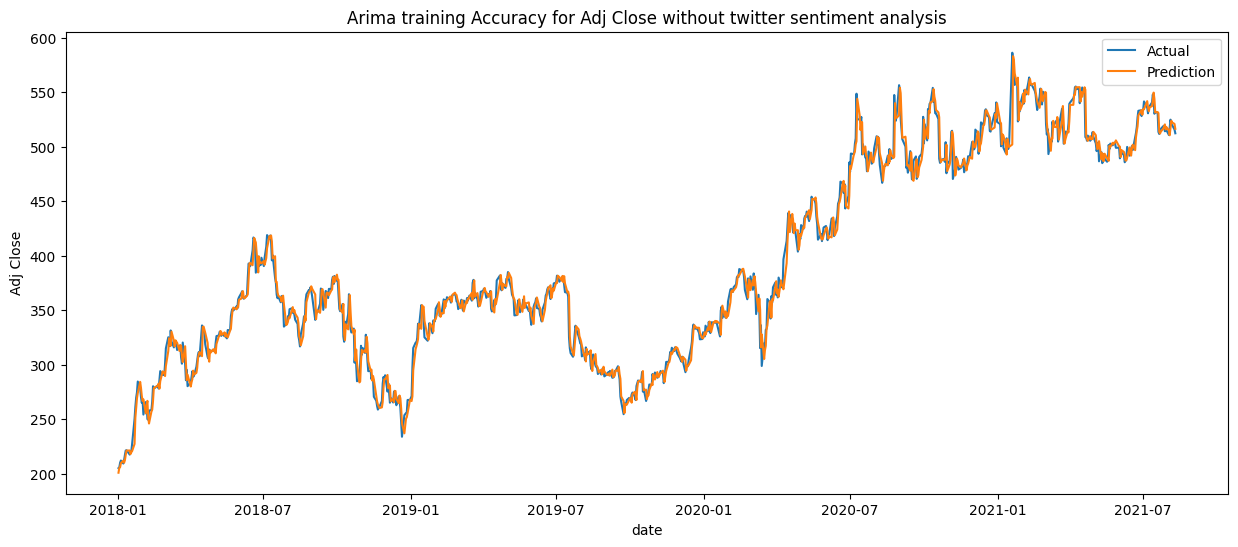

Training mean absolute error for Adj Close feature without twitter 101.41271934040135


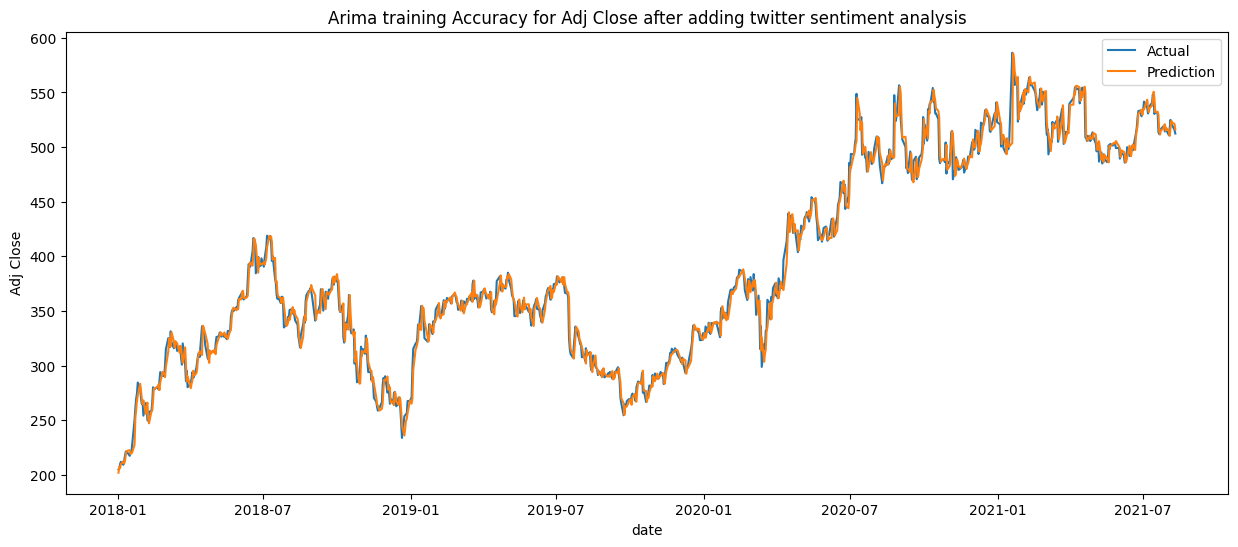

Training mean absolute error for Adj Close feature with twitter 100.65850944283414


In [25]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
train_prediction_without_twitter= arima_model_for_Adj_Close_without_twitter.predict(n_periods=len(X_train_arima_without_twitter), exogenous=X_train_arima_without_twitter)
train_prediction_twitter= arima_model_for_Adj_Close_twitter.predict(n_periods=len(X_train_arima_twitter), exogenous=X_train_arima_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arima['Adj Close'].index, y=y_train_arima['Adj Close'], label='Actual')
sns.lineplot(x=y_train_arima['Adj Close'].index, y=train_prediction_without_twitter, label='Prediction')
plt.title('Arima training Accuracy for Adj Close without twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_without_twitter, y_train_arima['Adj Close'])
print(f'Training mean absolute error for Adj Close feature without twitter {e}')

plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arima['Adj Close'].index, y=y_train_arima['Adj Close'], label='Actual')
sns.lineplot(x=y_train_arima['Adj Close'].index, y=train_prediction_twitter, label='Prediction')
plt.title('Arima training Accuracy for Adj Close after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_twitter, y_train_arima['Adj Close'])
print(f'Training mean absolute error for Adj Close feature with twitter {e}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


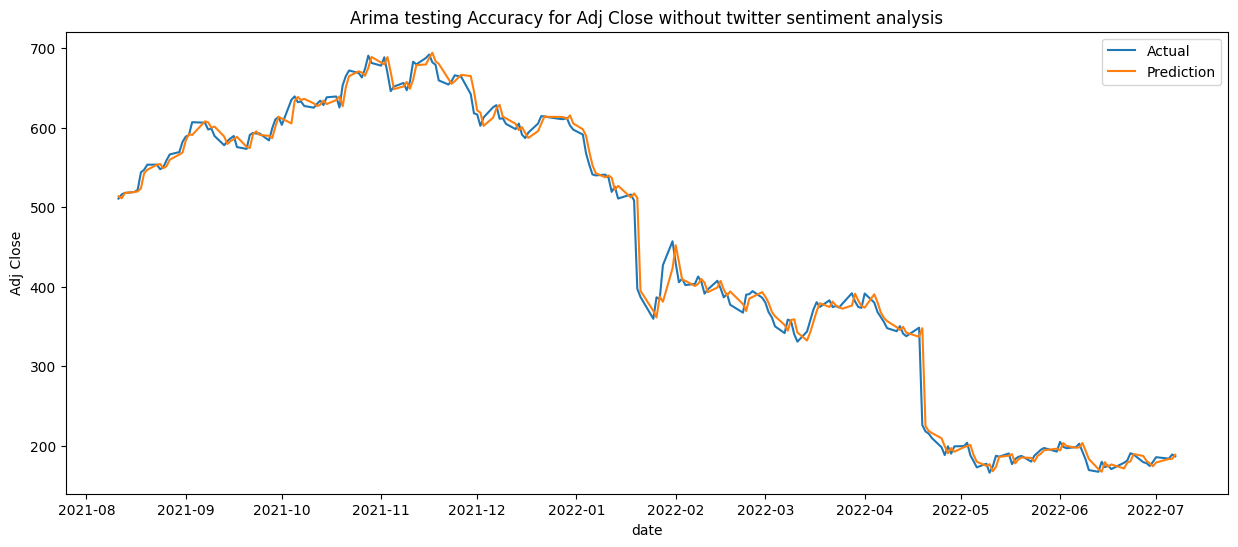

Testing absolute mean square error for Adj Close feature without twitter sentiment analysis 233.6436904706501


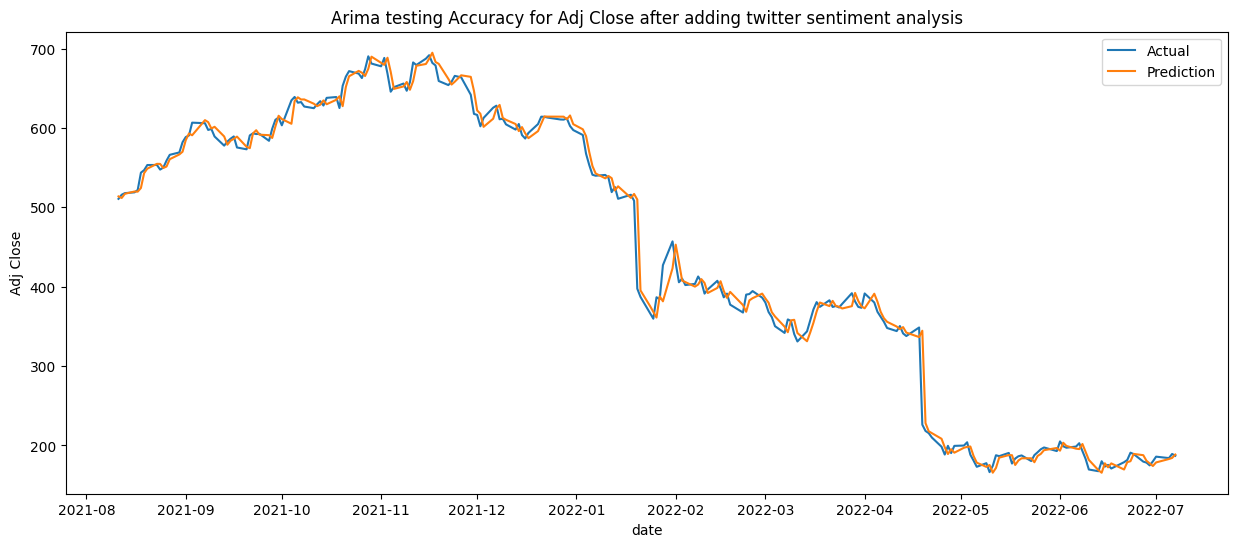

Testing absolute mean square error for Adj Close  feature with twitter sentiment analysis 229.54774967386263


In [26]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
test_prediction_without_twitter= arima_model_for_Adj_Close_without_twitter.predict(n_periods=len(X_test_arima_without_twitter), exogenous=X_test_arima_without_twitter)
test_prediction_twitter= arima_model_for_Adj_Close_twitter.predict(n_periods=len(X_test_arima_twitter), exogenous=X_test_arima_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arima['Adj Close'].index, y=y_test_arima['Adj Close'], label='Actual')
sns.lineplot(x=y_test_arima['Adj Close'].index, y=test_prediction_without_twitter, label='Prediction')
plt.title('Arima testing Accuracy for Adj Close without twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_without_twitter, y_test_arima['Adj Close'])
print(f'Testing absolute mean square error for Adj Close feature without twitter sentiment analysis {e}')
plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arima['Adj Close'].index, y=y_test_arima['Adj Close'], label='Actual')
sns.lineplot(x=y_test_arima['Adj Close'].index, y=test_prediction_twitter, label='Prediction')
plt.title('Arima testing Accuracy for Adj Close after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_twitter, y_test_arima['Adj Close'])
print(f'Testing absolute mean square error for Adj Close  feature with twitter sentiment analysis {e}')

In [27]:
test_prediction_twitter

array([513.75586033, 511.84611323, 517.09114869, 519.96867712,
       519.77747996, 524.36437738, 543.09174415, 548.7671655 ,
       554.81276657, 554.74944963, 549.63166639, 551.42323424,
       560.65906132, 566.66430111, 570.06214121, 584.61470682,
       593.05296622, 590.8511389 , 609.88445308, 607.40697805,
       599.32726529, 601.50460369, 589.32742464, 578.91475318,
       583.98945116, 586.31073349, 589.14299298, 576.2502058 ,
       574.57245216, 593.17886168, 597.19301478, 591.55942175,
       590.94817832, 587.45158809, 601.98454989, 615.39450193,
       611.28930976, 605.32250834, 633.89225009, 638.65702161,
       635.91655157, 635.98691185, 630.58660386, 627.53112516,
       629.28890452, 634.76155233, 629.9363283 , 635.53499865,
       639.95682089, 627.4771679 , 651.85053929, 665.16782929,
       671.94636627, 669.67505476, 665.51323147, 674.54279407,
       689.84885235, 682.20040544, 679.54417466, 688.53116976,
       670.79195679, 649.28882594, 652.35428962, 657.98

In [28]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past_dates = 5
n_days_for_prediction = 5 #let us predict past 15 days

predict_period_dates = pd.date_range(list(df_for_training.index)[-n_past_dates], periods=n_days_for_prediction,
                                     freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2022-07-01 00:00:00', freq='C'), Timestamp('2022-07-05 00:00:00', freq='C'), Timestamp('2022-07-06 00:00:00', freq='C'), Timestamp('2022-07-07 00:00:00', freq='C'), Timestamp('2022-07-08 00:00:00', freq='C')]


In [29]:
features= ['Open','High', 'Low','Close','Volume','Adj Close','P_mean']
df_for_training.iloc[-n_past:,:].to_numpy().reshape(1,n_past,len(features)).shape

(1, 5, 7)

In [32]:
x_forcast=X_arima[X_arima.index =='2022-07-07']
x_forcast

,High,Low,Close,Volume,P_mean,Adj Close_feature,open_feature_feature
date,,,,,,,
2022-07-07,190.210007,183.5,189.270004,6334500.0,-0.055427,189.270004,184.270004


In [33]:
x_forcast=X_arima[X_arima.index =='2022-07-07']
open_prediction = arima_model_for_open_twitter.predict(n_periods=len(x_forcast), exogenous=x_forcast)
adj_close_prediction = arima_model_for_Adj_Close_twitter.predict(n_periods=len(x_forcast),exogenous=x_forcast)#shape = (n, 1) where n is the n_days_for_prediction
# open_prediction=float(open_prediction)
# adj_close_prediction=float(adj_close_prediction)
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

print(f'Date = {forecast_dates[-2]}, Prediction open {open_prediction[0]}')
print(f'Date = {forecast_dates[-2]}, Prediction Adjusted close {adj_close_prediction[0]}')

Date = 2022-07-07, Prediction open 188.97567376563424
Date = 2022-07-07, Prediction Adjusted close 188.53706619754672


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
